#Procesos de Markov 

Ajustar una serie de tiempo generada por un proceso autoregresivo utilizando procesos de Markov donde los estado para deducir la matriz de transición y las probabilidades iniciales se calculen utilizando: 

1. Umbralización de la serie de tiempo 
2. Clustering por K-means y Gaussian Mixture
3. Algoritmo de cadenas ocultas de Markov 

Además ajustar la misma serie con un regresor lineal basado en mínimos cuadrados y un perceptrón multicapa, con el objetivo de comparar los diferentes modelos.


### Important Packages

In [28]:
!pip install pandas_datareader hmmlearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api
from hmmlearn.hmm import GaussianHMM
from tensorflow import keras
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

### utils functions

In [29]:
np.random.seed(1)

def AR_process(alphas=[0.99],betas=[0]):
    # Simulate an AR(2) process
    alphas = np.array(alphas)
    betas = np.array(betas)
    # Python requires us to specify the zero-lag value which is 1
    # Also note that the alphas for the AR model must be negated
    # We also set the betas for the MA equal to 0 for an AR(p) model
    # For more information see the examples at statsmodels.org
    ar = np.r_[1, -alphas]
    ma = np.r_[1, betas]

    ar2 = statsmodels.tsa.arima_process.arma_generate_sample(ar=ar, ma=ma, nsample=n_samples)
    ar2 = ((ar2 - np.min(ar2))/(np.max(ar2)-np.min(ar2)))
    return ar2

def generate_trayectories(number,alpha=[0.99]):
    trayectories = []
    for i in range(number):
        trayectories.append(AR_process(alphas=alpha))
    return np.array(trayectories)

def get_state_maxtrix_clusters(trayectories, n_states=8, type='kmeans'):
    states_matrix = np.zeros(trayectories.shape)
    if type == 'kmeans':
        clust = KMeans(n_clusters=n_states, random_state=0).fit(trayectories.reshape(-1,1))
        clust_means = clust.cluster_centers_
    else: 
        clust = GaussianMixture(n_components=n_states, covariance_type='full').fit(trayectories.reshape(-1,1))
        clust_means = clust.means_
    for i in np.arange(trayectories.shape[0]):
      states_matrix[i] = clust.predict(trayectories[i].reshape(-1,1))
      threshodls = np.squeeze(clust_means)
    return states_matrix, np.sort(threshodls)

def get_state_matrix_bins(trayectories, n_states=8):
  bins = np.linspace(np.min(trayectories),np.max(trayectories),n_states)
  states_matrix = np.digitize(trayectories,bins[1:-1])
  return states_matrix, bins

def get_probability_transition_matrix(state_matrix):
  states = np.unique(state_matrix)
  probability_transition_matrix = np.zeros((states.shape[0], states.shape[0]))
  for i,s1 in enumerate(states):
    tray, t = np.where(state_matrix[:,:-1]==s1)
    t_1 = t + 1
    for j,s2 in enumerate(states):
      probability_transition_matrix[i,j] = np.round(np.sum(state_matrix[tray,t_1]==s2)/tray.shape[0],2)
  return probability_transition_matrix

def get_initial_state_probabilities(initial_state, states):
  initial_state_probabilities = np.zeros(states.shape[0])
  for i,s1 in enumerate(states):
    initial_state_probabilities[i] = np.round(np.sum(initial_state == s1)/initial_state.shape[0],2)
  return initial_state_probabilities

def generate_sequence_mc(N, A, C, details=False):

    """Generate observation and state sequence from given HMM

    Notebook: C5/C5S3_HiddenMarkovModel.ipynb

    Args:
        N: Number of observations to be generated
        A: State transition probability matrix of dimension I x I
        C: Initial state distribution  of dimension I
        B: Output probability matrix of dimension I x K
        details: If "True" then shows details


    Returns:
        O: Observation sequence of length N
        S: State sequence of length N
    """
    assert N > 0, "N should be at least one"
    I = A.shape[1]
    assert I == A.shape[0], "A should be an I-square matrix"
    assert I == C.shape[0], "Dimension of C should be I"

    S = np.zeros(N, int)
    for n in range(N):
        if n == 0:
            i = np.random.choice(np.arange(I), p=C)
        else:
            p =  p=A[i, :]
            p /= p.sum()
            i = np.random.choice(np.arange(I), p=p)
        S[n] = i
        if details:
            print('n = %d, S[%d] = %d' % (n, n, S[n]))
    return S

### 0. Initial Set up

In [30]:
n_samples = int(1024)

### 1. Thresholding Markov chain

In [31]:
trayectories = generate_trayectories(100, alpha=[0.999999])
state_matrix, bins = get_state_matrix_bins(trayectories, n_states=8)
pt_matrix = get_probability_transition_matrix(state_matrix)
pi_state = get_initial_state_probabilities(state_matrix[:,0], np.unique(state_matrix))

<ipython-input-32-8a7fdd084a5f>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


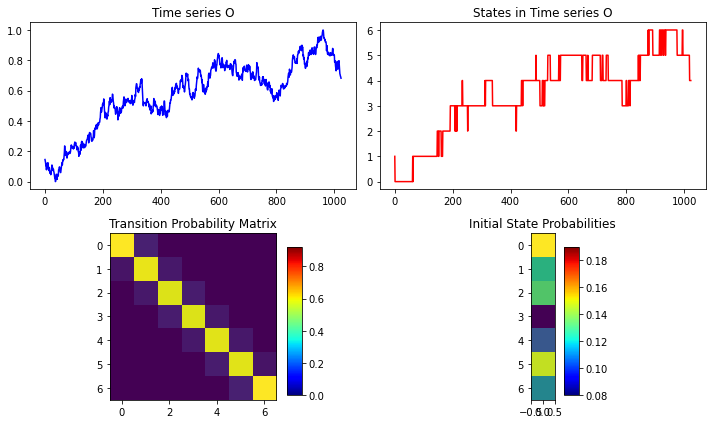

In [32]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0,0].plot(trayectories[0,:],'b')
axs[0,0].set_title('Time series O')
axs[0,1].plot(state_matrix[0,:], 'r')
axs[0,1].set_title('States in Time series O')
axs[1,0].imshow(pt_matrix)
sm1 = plt.cm.ScalarMappable(cmap='jet')
sm1.set_array(pt_matrix.ravel())
cax1 = fig.add_axes([axs[1,0].get_position().x1, axs[1,0].get_position().y0 - 0.05, 0.02, (axs[1,0].get_position().y1 - axs[1,0].get_position().y0)])
fig.colorbar(sm1,cax=cax1)
axs[1,0].set_title('Transition Probability Matrix')
axs[1,1].imshow(pi_state.reshape(-1,1))
sm2 = plt.cm.ScalarMappable(cmap='jet')
sm2.set_array(pi_state.ravel())
cax2 = fig.add_axes([axs[1,1].get_position().x1 + 0.05, axs[1,1].get_position().y0 - 0.05, 0.02, (axs[1,1].get_position().y1 - axs[1,1].get_position().y0)])
fig.colorbar(sm2,cax=cax2)
axs[1,1].set_title('Initial State Probabilities')
fig.tight_layout()

#### Generate sequence markov chains

In [33]:
generated_trayectory = generate_sequence_mc(n_samples, pt_matrix, pi_state)

Text(0.5, 1.0, 'Generated Trayectory')

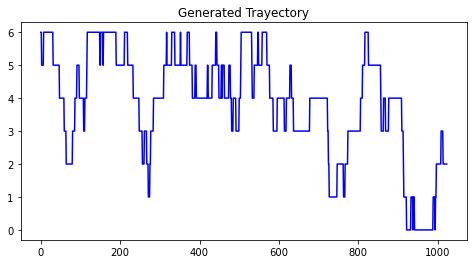

In [34]:
fig, axs = plt.subplots(1,1, figsize=(8,4))
axs.plot(generated_trayectory,'b')
axs.set_title('Generated Trayectory')

#### AR regression model

In [35]:
model_AR = ARMA(generated_trayectory, order=(1,0))
result_AR = model_AR.fit()

C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [36]:
print(result_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1024
Model:                     ARMA(1, 0)   Log Likelihood                -289.198
Method:                       css-mle   S.D. of innovations              0.320
Date:                Tue, 05 Oct 2021   AIC                            584.395
Time:                        16:25:30   BIC                            599.190
Sample:                             0   HQIC                           590.012
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8813      0.509      7.632      0.000       2.884       4.878
ar.L1.y        0.9812      0.006    164.979      0.000       0.970       0.993
                                    Roots           

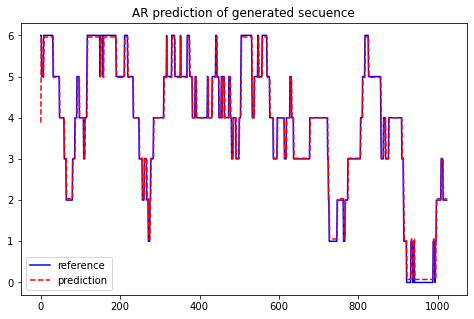

In [37]:
y_pred = model_AR.predict(result_AR.params)

fig3, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(generated_trayectory, 'b')
axs.plot(y_pred, 'r--')
axs.set_title('AR prediction of generated secuence')
axs.legend(labels=['reference','prediction'], loc='lower left')

### 2. Clustering Markov chain

In [38]:
trayectories = generate_trayectories(100, alpha=[0.999999])
state_matrix, bins = get_state_maxtrix_clusters(trayectories, n_states=8)
pt_matrix = get_probability_transition_matrix(state_matrix)
pi_state = get_initial_state_probabilities(state_matrix[:,0], np.unique(state_matrix))

<ipython-input-39-8a7fdd084a5f>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


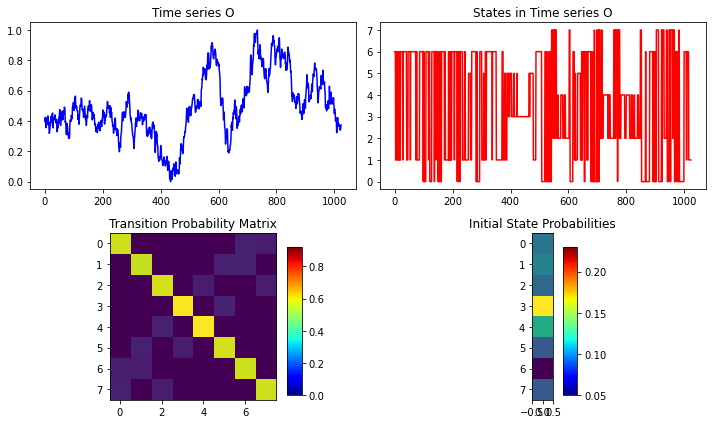

In [39]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0,0].plot(trayectories[0,:],'b')
axs[0,0].set_title('Time series O')
axs[0,1].plot(state_matrix[0,:], 'r')
axs[0,1].set_title('States in Time series O')
axs[1,0].imshow(pt_matrix)
sm1 = plt.cm.ScalarMappable(cmap='jet')
sm1.set_array(pt_matrix.ravel())
cax1 = fig.add_axes([axs[1,0].get_position().x1, axs[1,0].get_position().y0 - 0.05, 0.02, (axs[1,0].get_position().y1 - axs[1,0].get_position().y0)])
fig.colorbar(sm1,cax=cax1)
axs[1,0].set_title('Transition Probability Matrix')
axs[1,1].imshow(pi_state.reshape(-1,1))
sm2 = plt.cm.ScalarMappable(cmap='jet')
sm2.set_array(pi_state.ravel())
cax2 = fig.add_axes([axs[1,1].get_position().x1 + 0.05, axs[1,1].get_position().y0 - 0.05, 0.02, (axs[1,1].get_position().y1 - axs[1,1].get_position().y0)])
fig.colorbar(sm2,cax=cax2)
axs[1,1].set_title('Initial State Probabilities')
fig.tight_layout()

#### Generate sequence with markov chains

In [40]:
generated_trayectory = generate_sequence_mc(n_samples, pt_matrix, pi_state)

Text(0.5, 1.0, 'Generated Trayectory')

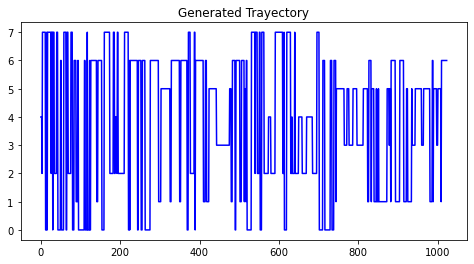

In [41]:
fig, axs = plt.subplots(1,1, figsize=(8,4))
axs.plot(generated_trayectory,'b')
axs.set_title('Generated Trayectory')

#### AR regression model

In [42]:
model_AR = ARMA(generated_trayectory, order=(1,0))
result_AR = model_AR.fit()

C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [43]:
print(result_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1024
Model:                     ARMA(1, 0)   Log Likelihood               -2053.490
Method:                       css-mle   S.D. of innovations              1.797
Date:                Tue, 05 Oct 2021   AIC                           4112.980
Time:                        16:25:36   BIC                           4127.775
Sample:                             0   HQIC                          4118.597
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8483      0.170     22.608      0.000       3.515       4.182
ar.L1.y        0.6707      0.023     28.979      0.000       0.625       0.716
                                    Roots           

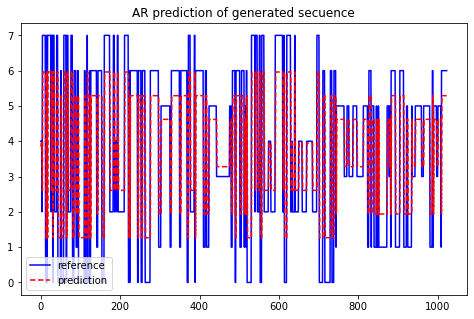

In [44]:
y_pred = model_AR.predict(result_AR.params)

fig3, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(generated_trayectory, 'b')
axs.plot(y_pred, 'r--')
axs.set_title('AR prediction of generated secuence')
axs.legend(labels=['reference','prediction'], loc='lower left')

### 3. Hidden Markov Chains

In [45]:
trayectorie = generate_trayectories(30, alpha=[0.999999])
model =  GaussianHMM(n_components=8, covariance_type='diag', n_iter=1000, verbose=0)
model.fit(list(trayectorie.reshape(-1,1)))

GaussianHMM(n_components=8, n_iter=1000, verbose=0)

<ipython-input-46-a467182c2755>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


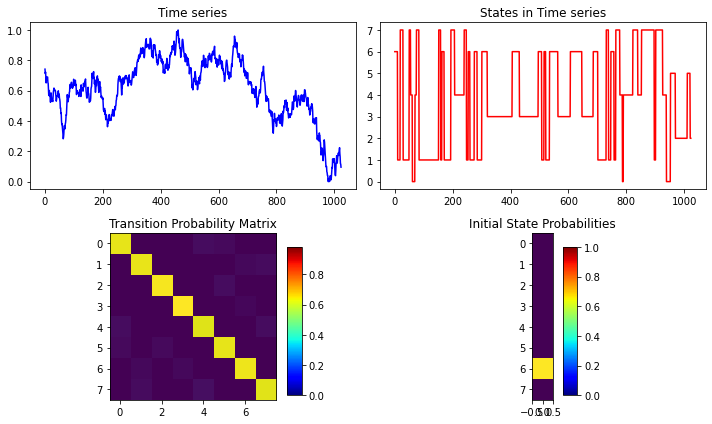

In [46]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0,0].plot(trayectorie[0],'b')
axs[0,0].set_title('Time series')
axs[0,1].plot(model.predict(trayectorie[0].reshape(-1,1)), 'r')
axs[0,1].set_title('States in Time series')
axs[1,0].imshow(model.transmat_)
sm1 = plt.cm.ScalarMappable(cmap='jet')
sm1.set_array(model.transmat_.ravel())
cax1 = fig.add_axes([axs[1,0].get_position().x1, axs[1,0].get_position().y0 - 0.05, 0.02, (axs[1,0].get_position().y1 - axs[1,0].get_position().y0)])
fig.colorbar(sm1,cax=cax1)
axs[1,0].set_title('Transition Probability Matrix')
axs[1,1].imshow(model.startprob_.reshape(-1,1))
sm2 = plt.cm.ScalarMappable(cmap='jet')
sm2.set_array(model.startprob_.ravel())
cax2 = fig.add_axes([axs[1,1].get_position().x1 + 0.05, axs[1,1].get_position().y0 - 0.05, 0.02, (axs[1,1].get_position().y1 - axs[1,1].get_position().y0)])
fig.colorbar(sm2,cax=cax2)
axs[1,1].set_title('Initial State Probabilities')
fig.tight_layout()

In [47]:
generated_trayectory, _ = model.sample(1024)

Text(0.5, 1.0, 'Generated Trayectory')

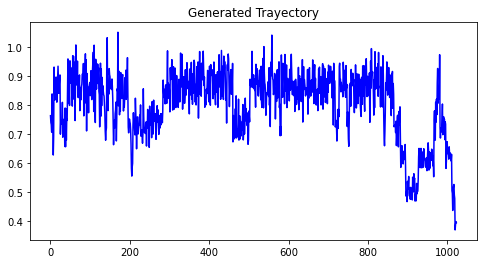

In [48]:
fig, axs = plt.subplots(1,1, figsize=(8,4))
axs.plot(generated_trayectory,'b')
axs.set_title('Generated Trayectory')

In [49]:
model_AR = ARMA(generated_trayectory, order=(1,0))
result_AR = model_AR.fit()

C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [50]:
print(result_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1024
Model:                     ARMA(1, 0)   Log Likelihood                1261.635
Method:                       css-mle   S.D. of innovations              0.071
Date:                Tue, 05 Oct 2021   AIC                          -2517.271
Time:                        16:25:52   BIC                          -2502.476
Sample:                             0   HQIC                         -2511.654
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8033      0.010     76.881      0.000       0.783       0.824
ar.L1.y        0.7898      0.019     40.660      0.000       0.752       0.828
                                    Roots           

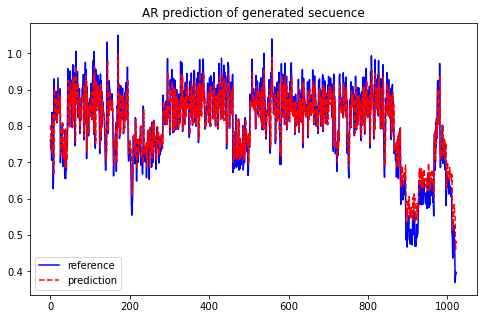

In [51]:
y_pred = model_AR.predict(result_AR.params)

fig3, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(generated_trayectory, 'b')
axs.plot(y_pred, 'r--')
axs.set_title('AR prediction of generated secuence')
axs.legend(labels=['reference','prediction'], loc='lower left')

### 4. Ordinary Least Square Error

In [52]:
x = AR_process(alphas=[0.25])
x, y = x[:-1], x[1:]
x_train, x_val =  x[:800], x[800:]
y_train, y_val = y[:800], y[800:]

In [53]:
model = statsmodels.api.OLS(y_train, x_train)
result = model.fit()
print('R^2 = ',result.rsquared)
print('p value = ', result.pvalues)
y_train_pred = model.predict(result.params)
y_val_pred = model.predict(result.params, x_val.reshape(-1,1))

R^2 =  0.8534969024588559
p value =  [0.]


Text(0, 0.5, '$x_{t+1}$')

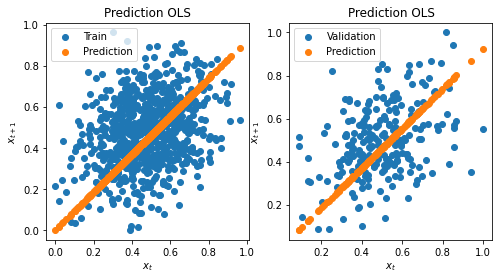

In [54]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.scatter(x_train, y_train_pred)
plt.title('Prediction OLS')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')
plt.legend(['Train','Prediction'])
plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.scatter(x_val, y_val_pred)
plt.legend(['Validation','Prediction'])
plt.title('Prediction OLS')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')

### 5. NN

Text(0.5, 0, '$t$')

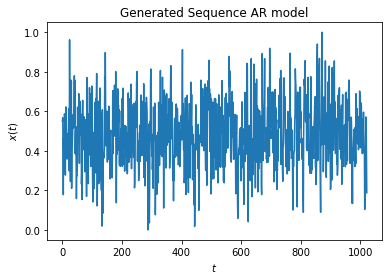

In [55]:
plt.plot(x)
plt.title('Generated Sequence AR model')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')

In [56]:
model = keras.Sequential([keras.layers.Input(shape=[1]),keras.layers.Dense(1, activation='linear', use_bias=False, name='output')])
model.compile(optimizer='adam', loss=keras.losses.mean_squared_error)
history = model.fit(x_train,y_train,epochs=50, validation_data=(x_val, y_val), verbose=0)

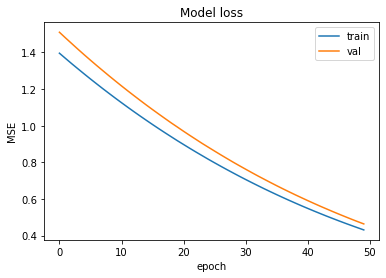

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Text(0, 0.5, '$x_{t+1}$')

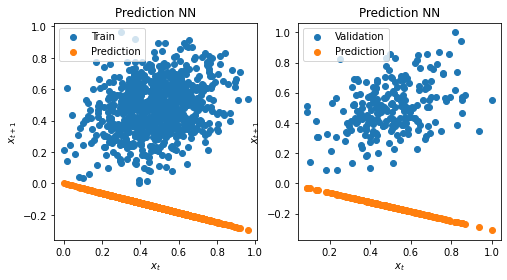

In [58]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.scatter(x_train, model.predict(x_train))
plt.title('Prediction NN')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')
plt.legend(['Train','Prediction'])
plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.scatter(x_val, model.predict(x_val))
plt.legend(['Validation','Prediction'])
plt.title('Prediction NN')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')

In [59]:
w = model.get_layer('output').get_weights()[0][0]
print('Weights = ',w)

Weights =  [-0.3087576]


In [60]:
print('R^2 = ',r2_score(y_train, model.predict(x_train)))
print('p value = ', stats.kstest(model.predict(x_train), 'norm').pvalue)
print('p value = ', stats.ttest_ind(model.predict(x_train), y_train).pvalue)

R^2 =  -14.768121531970328
p value =  1.680244181517868e-293
p value =  [0.]


## Referencias 

* [Markov processes](https://www.randomservices.org/random/markov/index.html)